In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.feature_extraction import stop_words
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

%matplotlib inline

# Pull data from MongoDB into a pandas dataframe

In [2]:
client = MongoClient()
# client.list_database_names()
db = client.script
db.list_collection_names()

['lines']

In [3]:
little_women = pd.DataFrame(list(db.lines.find({},{'_id':0})))

In [4]:
little_women.head(10)

,speaker,text,slug_line,year,time_period,scene_index,dialogue_index,place,time_of_day,listener
0,Jo,Excuse me.,INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,0,publishing house,day,Jo
1,Jo,"A friend of mine desired me to offer a story, ...",INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,2,publishing house,day,Mr. Dashwood
2,Mr. Dashwood,A prize?,INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,5,publishing house,day,Jo
3,Jo,"No, sir; she has sold to “Olympic” and “Scanda...",INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,4,publishing house,day,Mr. Dashwood
4,Jo,Yes.,INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,6,publishing house,day,Mr. Dashwood
5,Mr. Dashwood,Sit.,INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,7,publishing house,day,Mr. Dashwood
6,Mr. Dashwood,We’ll take this.,INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,8,publishing house,day,Jo
7,Mr. Dashwood,With alterations. It’s too long.,INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,10,publishing house,day,Jo
8,Jo,You will?,INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,9,publishing house,day,Mr. Dashwood
9,Mr. Dashwood,"Not a first attempt, I take it?",INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,3,publishing house,day,Jo


# Topic Modeling (themes)

## Different ways to group the lines of dialogue

### By lines of dialogue 

In [5]:
little_women['clean'] = little_women.text
little_women.clean = little_women.clean.str.replace("/","")
little_women.clean = little_women.clean.str.replace('”',"")
little_women.clean = little_women.clean.str.replace('“',"")
little_women.clean = little_women.clean.str.replace("I’ll","I will")
little_women.clean = little_women.clean.str.replace("’","")

In [6]:
little_women.clean = [(re.sub('[%s]' % re.escape(string.punctuation), ' ',i)) for i in little_women.clean]
little_women.clean = [(re.sub('\w*\d\w*', ' ',i)) for i in little_women.clean]

little_women.clean

0                                              Excuse me 
1       A friend of mine desired me to offer a story  ...
2                                                A prize 
3       No  sir  she has sold to Olympic and Scandal a...
4                                                    Yes 
                              ...                        
1214    If Im going to sell my heroine into marriage f...
1215                               Six point six percent 
1216                                                Done 
1217    And you dont need to decide about the copyrigh...
1218              Ive decided  I want to own my own book 
Name: clean, Length: 1219, dtype: object

In [7]:
little_women.head(5)

,speaker,text,slug_line,year,time_period,scene_index,dialogue_index,place,time_of_day,listener,clean
0,Jo,Excuse me.,INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,0,publishing house,day,Jo,Excuse me
1,Jo,"A friend of mine desired me to offer a story, ...",INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,2,publishing house,day,Mr. Dashwood,A friend of mine desired me to offer a story ...
2,Mr. Dashwood,A prize?,INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,5,publishing house,day,Jo,A prize
3,Jo,"No, sir; she has sold to “Olympic” and “Scanda...",INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,4,publishing house,day,Mr. Dashwood,No sir she has sold to Olympic and Scandal a...
4,Jo,Yes.,INT. NEW YORK. PUBLISHING OFFICE. 1868.,1868,present,0,6,publishing house,day,Mr. Dashwood,Yes


### By a speaker's dialogue in a given scene

In [8]:
metadata = little_women.groupby(['speaker', 'scene_index'])['year', 'time_period', 'place', 'time_of_day'].first()
metadata.reset_index()

,speaker,scene_index,year,time_period,place,time_of_day
0,Amy,4,1868,present,paris,day
1,Amy,11,1861,past,march house,night
2,Amy,16,1861,past,march house,night
3,Amy,19,1868,present,paris,night
4,Amy,24,1861,past,march house,day
...,...,...,...,...,...,...
263,Servant,39,1862,past,laurence house,day
264,Soldier,70,1862,past,inside in concord,day
265,Susan Robbins,70,1862,past,inside in concord,day
266,Viola,8,1868,present,new york,night


In [9]:
by_speaker_scene= pd.DataFrame()

In [10]:
by_speaker_scene['text'] = little_women.groupby(['speaker', 'scene_index'])['text'].apply(lambda x: ' '.join(x))

In [11]:
by_speaker_scene.text = by_speaker_scene.text.str.replace("/","")
by_speaker_scene.text = by_speaker_scene.text.str.replace("”",'')
by_speaker_scene.text = by_speaker_scene.text.str.replace("“",'')
by_speaker_scene.text = by_speaker_scene.text.str.replace("I’ll",'I will')
by_speaker_scene.text = by_speaker_scene.text.str.replace("’","")
by_speaker_scene.text =by_speaker_scene.text.apply(lambda x: (re.sub('[%s]' % re.escape(string.punctuation), ' ',x)))
by_speaker_scene.text =by_speaker_scene.text.apply(lambda x: (re.sub('\w*\d\w*', ' ',x)))

In [12]:
by_speaker_scene.reset_index()

,speaker,scene_index,text
0,Amy,4,Oh yes Very true Aunt March Mother doesnt s...
1,Amy,11,Who will you dance with Jo Why cant we all g...
2,Amy,16,Tell us about it Whats he like Im Amy
3,Amy,19,Laurie I waited an hour for you Do you want ...
4,Amy,24,No no poison its Christmas I dont think its ...
...,...,...,...
263,Servant,39,Shes in here
264,Soldier,70,Mrs March Telegram from Washington Ma am
265,Susan Robbins,70,You should go home to the girls I can take ca...
266,Viola,8,Then think you right I am not what I am


In [13]:
by_speaker_scene = pd.merge(by_speaker_scene, metadata, on=['speaker','scene_index'])
by_speaker_scene =by_speaker_scene.reset_index()

## Stop words list

In [14]:
my_stop_words=list(stop_words.ENGLISH_STOP_WORDS)
lemmatizer = WordNetLemmatizer()
my_stop_words_lem = [lemmatizer.lemmatize(i) for i in my_stop_words]

In [15]:
word_list = ['jo','amy', 'beth', 'meg', 'march', 'laurie', 'teddy', 'brooke',
             'john', 'mr', 'fred', 'marmee', 'aunt','laurence', 'daisy',
             'dont', 'youll','ive', 'isnt', 'doesnt','im', 'youre', 'didnt', 'id', 'youve',
             'just', 'wont', 'thats', 'youd', 'arent', 'theyre', 'havent', 'wouldnt', 'don', 'shes',
              'oh', 'lot', 'really', 'course', #as in "of course"
             'got', 'did', 'way', 't', 'sorry', 'thank', 'day', 
             'come', 'look', 'right',
             'yes', 'good', 'thing', 'think', 'like', 'know','feel', 'merry',
              'going', 'quite', 'whats', 'long', 'better',
             'suppose', 'say', 'need', 'wish', 'wished', 'little', 'make', 
             'want', 'wanted', 'use', 'stay', 'let', 'mean', 'said', 'half', 'night',
             'tell', 'fine', 'care', 'time', 'tried', 'doe',
             'blue', 'nose', 'mind', 'horse', 'meant','wicked','woman'
            ]

#creating the stop words list was an iterative process as topic modeling was run repeatedly
#goal was distinct, meaningful topics
for i in word_list:
    my_stop_words_lem.append(i)

In [16]:
my_stop_words_lem.sort()
# my_stop_words_lem

## Lemmatizer

In [17]:
class LemmaTokenizer:
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

## CountVectorizer

In [18]:
vectorizer = CountVectorizer(stop_words=my_stop_words_lem, 
#                              token_pattern='\\b[a-z][a-z]+\\b',
                             max_df=.9, min_df=2,
                             lowercase = True,
                             tokenizer=LemmaTokenizer()
                            ) 

In [19]:
# doc_word = vectorizer.fit_transform(little_women.clean)
doc_word = vectorizer.fit_transform(by_speaker_scene.text)

In [20]:
# pd.DataFrame(doc_word.toarray(), index=little_women.clean, columns=vectorizer.get_feature_names()).head(5)
pd.DataFrame(doc_word.toarray(), index=by_speaker_scene.text, columns=vectorizer.get_feature_names())
#matrix V

,accept,accomplished,acting,actress,actually,adore,afford,afraid,afternoon,age,...,writer,writes,writing,written,wrong,wrote,yard,year,york,young
text,,,,,,,,,,,,,,,,,,,,,
Oh yes Very true Aunt March Mother doesnt say anything about Beth I feel I should go back but they all say stay STOP THE CARRIAGE LAURIE LAURIE Yes and until Ive completed all of my painting lessons of course You wrote youd come to the hotel You didnt look hard enough Please dont and drinking and gambling and flirting Are you chasing some young girl across Europe NO Wheres your Grandfather Im I couldnt believe Jo turned you down Im so sorry Oh Aunt March Come to the New Years Party Its a ball and everyone will be there including Fred Pick me up at the hotel at eight the Chavain Dress for festivities Top hats and silks Its Laurie,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
Who will you dance with Jo Why cant we all go to the party Its not fair You could be pretty if you tried What a queer smell its like burnt feathers Youre ruined Now Jo My nose will simply not look refined,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tell us about it Whats he like Im Amy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Laurie I waited an hour for you Do you want to know what I honestly think of you I despise you Because with every chance for being good useful and happy you are faulty lazy and miserable Selfish people do like to talk about themselves ah you like that you old vanity with all these good things to enjoy you can find nothing to do but dawdle Arent you ashamed of a hand like that Yes very selfish With your money talent beauty and health I feel sorry for you I really do I just wish youd bear it better No Id be respected if I couldnt be loved Fred Im Im so sorry It looks like its never done a day of work in its life And that ring is ridiculous,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
No no poison its Christmas I dont think its fair for some girls to have lots of pretty things and other girls nothing at all I have lots of wishes but my favorite one is to be an artist and go to Paris and do fine pictures and be the best painter in the world Why be ashamed of what you want Beth is perfect Dont Jo its so boyish I detest rude unlady like girls Watch my nose My nose Its already no good You must not limit yourself Dolls dont get hungry Beth Where is Marmee Ive made a DIVINE hat and painted those old shoes blue so she truly looks like a princess I cant help it I never saw anyone faint and I dont choose to make myself all black and blue If I can go down easily I will drop If I cant I shall fall into a chair and be graceful I dont care if Hugo does come at me with a pistol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Shes in here,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mrs March Telegram from Washington Ma am,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
You should go home to the girls I can take care of this No offense meant but you should still be ashamed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## NMF

In [21]:
def display_topics(model_name, feature_names, num_topic_words, topic_names=None):
    '''
    prints topic name (or Topic number) followed by 
    terms most likely to be associated with the topic
    '''
    
    for ix, topic in enumerate(model_name.components_):
        if not topic_names or not topic_names[ix]: 
            print("\nTopic ", ix) 
        else:
            print("\nTopic: ",topic_names[ix])
        print(", ".join([feature_names[i] 
                        for i in topic.argsort()[:-num_topic_words - 1:-1]]))    

In [22]:
def topic_modeling(num_topics):
    nmf = NMF(num_topics)
    doc_topic = nmf.fit_transform(doc_word) #create coefficients matrix H 
    
    topic_word = pd.DataFrame(nmf.components_.round(3),
                 columns = vectorizer.get_feature_names()) #create features matrix W

    display_topics(nmf, vectorizer.get_feature_names(), 5)
    
#     H = pd.DataFrame(doc_topic.round(5),
#              index = by_speaker_scene_lem)
    
#     return H

In [23]:
topic_modeling(4)


Topic  0
talent, genius, money, hope, rich

Topic  1
girl, christmas, mother, school, father

Topic  2
love, help, loved, home, happy

Topic  3
percent, copyright, money, book, work


## Final topics

In [24]:
nmf = NMF(4)
doc_topic = nmf.fit_transform(doc_word)
    
topic_word = pd.DataFrame(nmf.components_.round(3), #topics and the most associated words
             columns = vectorizer.get_feature_names())

#assigned topic names
display_topics(nmf, vectorizer.get_feature_names(), 7, topic_names=["Aspiration", "Childhood", "Family", "Writing"])
    
H = pd.DataFrame(doc_topic.round(5), #coefficients matrix df (how each doc is made up of the topics)
         index = by_speaker_scene)


Topic:  Aspiration
talent, genius, money, hope, rich, belong, failure

Topic:  Childhood
girl, christmas, mother, school, father, work, best

Topic:  Family
love, help, loved, home, happy, friend, married

Topic:  Writing
percent, copyright, money, book, work, printing, story


In [25]:
topic_word

,accept,accomplished,acting,actress,actually,adore,afford,afraid,afternoon,age,...,writer,writes,writing,written,wrong,wrote,yard,year,york,young
0,0.007,0.009,0.000,0.018,0.012,0.003,0.002,0.007,0.022,0.040,...,0.311,0.000,0.000,0.004,0.016,0.000,0.000,0.034,0.355,0.048
1,0.006,0.052,0.022,0.092,0.042,0.015,0.011,0.003,0.000,0.029,...,0.028,0.033,0.218,0.053,0.056,0.046,0.002,0.126,0.000,0.162
2,0.010,0.093,0.000,0.012,0.000,0.102,0.006,0.039,0.000,0.000,...,0.089,0.026,0.173,0.103,0.087,0.009,0.011,0.015,0.056,0.000
3,0.010,0.000,0.100,0.063,0.000,0.000,0.095,0.000,0.035,0.000,...,0.000,0.000,0.000,0.004,0.000,0.107,0.000,0.044,0.000,0.000


In [26]:
H = H.rename(columns={0:'aspiration',
                      1:'childhood',
                      2:'family',
                      3:'writing'})

In [27]:
H

,aspiration,childhood,family,writing
"(Amy, 4, Oh yes Very true Aunt March Mother doesnt say anything about Beth I feel I should go back but they all say stay STOP THE CARRIAGE LAURIE LAURIE Yes and until Ive completed all of my painting lessons of course You wrote youd come to the hotel You didnt look hard enough Please dont and drinking and gambling and flirting Are you chasing some young girl across Europe NO Wheres your Grandfather Im I couldnt believe Jo turned you down Im so sorry Oh Aunt March Come to the New Years Party Its a ball and everyone will be there including Fred Pick me up at the hotel at eight the Chavain Dress for festivities Top hats and silks Its Laurie , 1868, present, paris, day)",0.09743,0.58953,0.04521,0.00000
"(Amy, 11, Who will you dance with Jo Why cant we all go to the party Its not fair You could be pretty if you tried What a queer smell its like burnt feathers Youre ruined Now Jo My nose will simply not look refined , 1861, past, march house, night)",0.00000,0.07139,0.00000,0.00000
"(Amy, 16, Tell us about it Whats he like Im Amy , 1861, past, march house, night)",0.00000,0.00000,0.00000,0.00000
"(Amy, 19, Laurie I waited an hour for you Do you want to know what I honestly think of you I despise you Because with every chance for being good useful and happy you are faulty lazy and miserable Selfish people do like to talk about themselves ah you like that you old vanity with all these good things to enjoy you can find nothing to do but dawdle Arent you ashamed of a hand like that Yes very selfish With your money talent beauty and health I feel sorry for you I really do I just wish youd bear it better No Id be respected if I couldnt be loved Fred Im Im so sorry It looks like its never done a day of work in its life And that ring is ridiculous , 1868, present, paris, night)",0.32268,0.07163,0.05665,0.34549
"(Amy, 24, No no poison its Christmas I dont think its fair for some girls to have lots of pretty things and other girls nothing at all I have lots of wishes but my favorite one is to be an artist and go to Paris and do fine pictures and be the best painter in the world Why be ashamed of what you want Beth is perfect Dont Jo its so boyish I detest rude unlady like girls Watch my nose My nose Its already no good You must not limit yourself Dolls dont get hungry Beth Where is Marmee Ive made a DIVINE hat and painted those old shoes blue so she truly looks like a princess I cant help it I never saw anyone faint and I dont choose to make myself all black and blue If I can go down easily I will drop If I cant I shall fall into a chair and be graceful I dont care if Hugo does come at me with a pistol , 1861, past, march house, day)",0.00000,1.31722,0.00000,0.00000
...,...,...,...,...
"(Servant, 39, Shes in here , 1862, past, laurence house, day)",0.00000,0.00000,0.00000,0.00000
"(Soldier, 70, Mrs March Telegram from Washington Ma am , 1862, past, inside in concord, day)",0.00000,0.00291,0.00146,0.00000
"(Susan Robbins, 70, You should go home to the girls I can take care of this No offense meant but you should still be ashamed , 1862, past, inside in concord, day)",0.01547,0.33145,0.00000,0.00000
"(Viola, 8, Then think you right I am not what I am , 1868, present, new york, night)",0.00000,0.00000,0.00000,0.00000


In [28]:
H['top_topic'] = H.T.apply(lambda x: x.nlargest(1).idxmin())
#sets the top topic as the one with the highest coefficient

In [29]:
H.index.names = ['speaker_scene_text']
H = H.reset_index()

In [30]:
H[['speaker', 'scene_index', 'text', 'year','time_period','place','time_of_day']] = pd.DataFrame(
    H['speaker_scene_text'].tolist(), index=H.index)
H

,speaker_scene_text,aspiration,childhood,family,writing,top_topic,speaker,scene_index,text,year,time_period,place,time_of_day
0,"(Amy, 4, Oh yes Very true Aunt March Mother...",0.09743,0.58953,0.04521,0.00000,childhood,Amy,4,Oh yes Very true Aunt March Mother doesnt s...,1868,present,paris,day
1,"(Amy, 11, Who will you dance with Jo Why can...",0.00000,0.07139,0.00000,0.00000,childhood,Amy,11,Who will you dance with Jo Why cant we all g...,1861,past,march house,night
2,"(Amy, 16, Tell us about it Whats he like Im ...",0.00000,0.00000,0.00000,0.00000,aspiration,Amy,16,Tell us about it Whats he like Im Amy,1861,past,march house,night
3,"(Amy, 19, Laurie I waited an hour for you Do...",0.32268,0.07163,0.05665,0.34549,writing,Amy,19,Laurie I waited an hour for you Do you want ...,1868,present,paris,night
4,"(Amy, 24, No no poison its Christmas I dont ...",0.00000,1.31722,0.00000,0.00000,childhood,Amy,24,No no poison its Christmas I dont think its ...,1861,past,march house,day
...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,"(Servant, 39, Shes in here , 1862, past, lau...",0.00000,0.00000,0.00000,0.00000,aspiration,Servant,39,Shes in here,1862,past,laurence house,day
264,"(Soldier, 70, Mrs March Telegram from Washin...",0.00000,0.00291,0.00146,0.00000,childhood,Soldier,70,Mrs March Telegram from Washington Ma am,1862,past,inside in concord,day
265,"(Susan Robbins, 70, You should go home to the ...",0.01547,0.33145,0.00000,0.00000,childhood,Susan Robbins,70,You should go home to the girls I can take ca...,1862,past,inside in concord,day
266,"(Viola, 8, Then think you right I am not what...",0.00000,0.00000,0.00000,0.00000,aspiration,Viola,8,Then think you right I am not what I am,1868,present,new york,night


## Create a df with topic weights for the dialogue grouped by character within a scene

In [31]:
topics_df = H.drop(columns=['speaker_scene_text'])

In [32]:
topics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 12 columns):
aspiration     268 non-null float64
childhood      268 non-null float64
family         268 non-null float64
writing        268 non-null float64
top_topic      268 non-null object
speaker        268 non-null object
scene_index    268 non-null int64
text           268 non-null object
year           268 non-null int64
time_period    268 non-null object
place          268 non-null object
time_of_day    268 non-null object
dtypes: float64(4), int64(2), object(6)
memory usage: 25.2+ KB


In [33]:
topics_df.head(5)

,aspiration,childhood,family,writing,top_topic,speaker,scene_index,text,year,time_period,place,time_of_day
0,0.09743,0.58953,0.04521,0.00000,childhood,Amy,4,Oh yes Very true Aunt March Mother doesnt s...,1868,present,paris,day
1,0.00000,0.07139,0.00000,0.00000,childhood,Amy,11,Who will you dance with Jo Why cant we all g...,1861,past,march house,night
2,0.00000,0.00000,0.00000,0.00000,aspiration,Amy,16,Tell us about it Whats he like Im Amy,1861,past,march house,night
3,0.32268,0.07163,0.05665,0.34549,writing,Amy,19,Laurie I waited an hour for you Do you want ...,1868,present,paris,night
4,0.00000,1.31722,0.00000,0.00000,childhood,Amy,24,No no poison its Christmas I dont think its ...,1861,past,march house,day


## Topics by main characters

### Average weights/coefficients of topics

In [34]:
main_characters= ['Jo', 'Amy', 'Meg','Beth',
#                   'Laurie','Marmee',
#                   'Aunt March','Friedrich', 'Mr. Dashwood'
                 ]

In [35]:
mean_topics =topics_df.groupby(['speaker'])['aspiration', 'childhood','family','writing'].mean().reset_index()
mean_topics= mean_topics[mean_topics['speaker'].isin(main_characters)]
mean_topics

,speaker,aspiration,childhood,family,writing
0,Amy,0.081303,0.120623,0.084310,0.025926
4,Beth,0.003768,0.063731,0.114803,0.002819
13,Jo,0.029952,0.101217,0.116847,0.074784
18,Meg,0.019650,0.061830,0.048122,0.032855


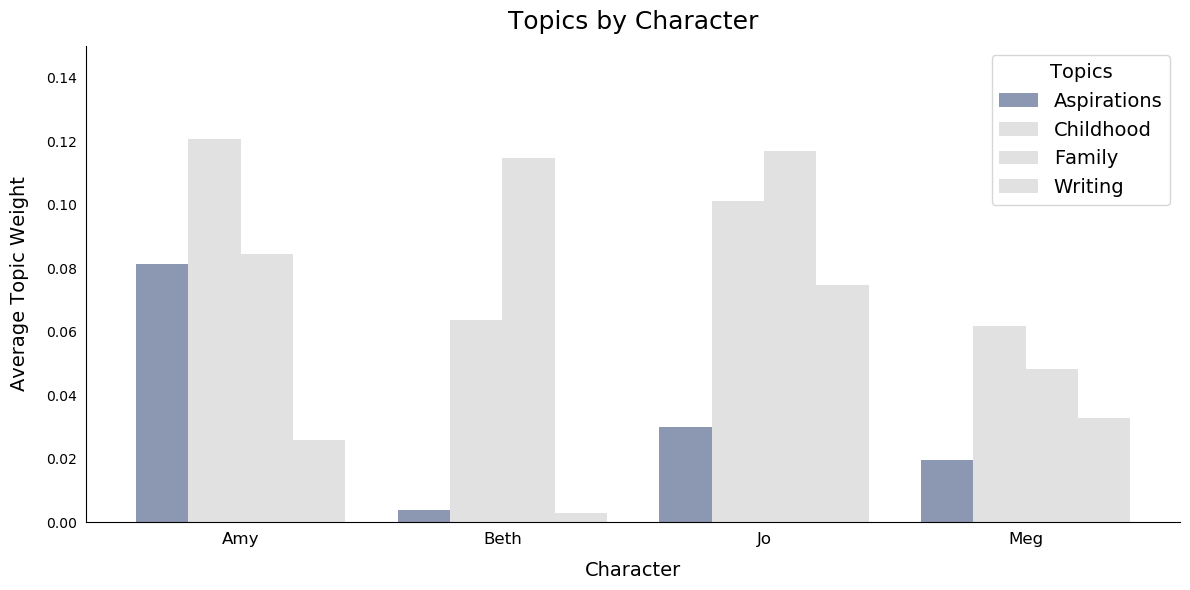

In [36]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(mean_topics.speaker.unique()))
bar_width = 0.2

#bars
b1 = ax.bar(x, mean_topics['aspiration'], 
            color='#8C97B1',
            width=bar_width, label='Aspirations')
b2 = ax.bar(x + bar_width, mean_topics['childhood'], 
            color='#E1E1E1',
            width=bar_width, label='Childhood')
b3 = ax.bar(x + bar_width*2, mean_topics['family'], 
            color='#E1E1E1',
            width=bar_width, label='Family')
b4 = ax.bar(x + bar_width*3, mean_topics['writing'], 
            color='#E1E1E1',
            width=bar_width, label='Writing')

# Adjust the axes.
ax.set_xticks(x + 1.5*bar_width )
ax.set_xticklabels(mean_topics.speaker, fontdict = {'size':12})
ax.set_ylim([0, .15])

# Add legend.
ax.legend(title="Topics",fontsize='14',title_fontsize='14')

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(False)
ax.xaxis.grid(False)

# Add axis and chart labels.
ax.set_xlabel('Character', labelpad=10, fontdict = {'size':14})
ax.set_ylabel('Average Topic Weight', labelpad=12, fontdict = {'size':14})
ax.set_title('Topics by Character', pad=12, fontdict = {'size':18})

fig.tight_layout()
plt.savefig('sisterswriting.png')


#highlighting aspirations- 
#Amy wants to be a famous artist, Jo a writer, Meg a wife and mother, 
#while Beth discuss the future much and ends up dying before pursuing a career

### Aggregated top topics

In [37]:
#for each character, creates a count of the number of times 
#each topic is the topic with the highest coefficent (top topic)

percent_top_topics = topics_df.groupby(['speaker'])['top_topic'].value_counts(normalize=True)[main_characters]
percent_top_topics

speaker  top_topic 
Amy      family        0.371429
         childhood     0.314286
         aspiration    0.200000
         writing       0.114286
Beth     family        0.631579
         childhood     0.368421
Jo       family        0.344828
         childhood     0.258621
         aspiration    0.224138
         writing       0.172414
Meg      childhood     0.393939
         family        0.272727
         writing       0.181818
         aspiration    0.151515
Name: top_topic, dtype: float64

In [38]:
#creates a df from the aggregated top topics values
for_graphing = pd.DataFrame(percent_top_topics)
for_graphing = for_graphing.rename(columns={'top_topic':'percent'})
for_graphing = for_graphing.reset_index()
for_graphing

,speaker,top_topic,percent
0,Amy,family,0.371429
1,Amy,childhood,0.314286
2,Amy,aspiration,0.200000
3,Amy,writing,0.114286
4,Beth,family,0.631579
5,Beth,childhood,0.368421
6,Jo,family,0.344828
7,Jo,childhood,0.258621
8,Jo,aspiration,0.224138
9,Jo,writing,0.172414


In [39]:
#transform data from long to wide
graphing = pd.pivot_table(for_graphing, index = 'speaker', columns = 'top_topic', values 
= 'percent').reset_index()
graphing

top_topic,speaker,aspiration,childhood,family,writing
0,Amy,0.200000,0.314286,0.371429,0.114286
1,Beth,NaN,0.368421,0.631579,NaN
2,Jo,0.224138,0.258621,0.344828,0.172414
3,Meg,0.151515,0.393939,0.272727,0.181818


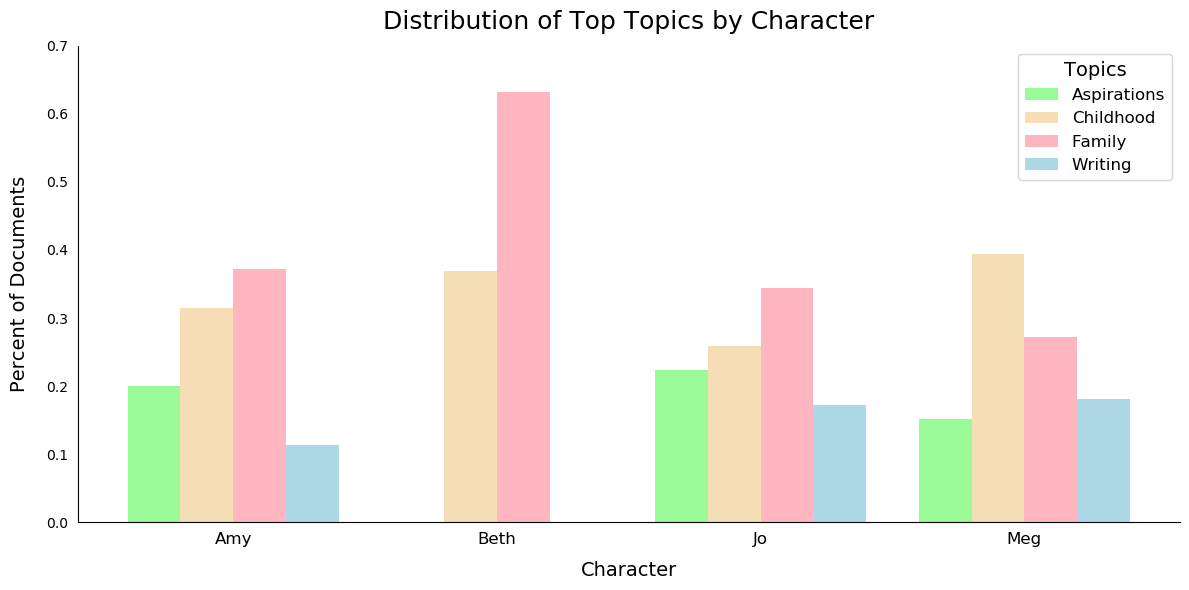

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(graphing.speaker.unique()))
bar_width = 0.2

#bars
b1 = ax.bar(x, graphing['aspiration'], color='palegreen',
            width=bar_width, label='Aspirations')
b2 = ax.bar(x + bar_width, graphing['childhood'], color='wheat',
            width=bar_width, label='Childhood')
b3 = ax.bar(x + bar_width*2, graphing['family'], color='lightpink',
            width=bar_width, label='Family')
b4 = ax.bar(x + bar_width*3, graphing['writing'], color='lightblue',
            width=bar_width, label='Writing')

# Adjust the axes.
ax.set_xticks(x + 1.5*bar_width )
ax.set_xticklabels(graphing.speaker, fontdict = {'size':12})
ax.set_ylim([0, .7])

# Add legend.
ax.legend(title="Topics",fontsize='12',title_fontsize='14')

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(False)
ax.xaxis.grid(False)

# Add axis and chart labels.
ax.set_xlabel('Character', labelpad=10, fontdict = {'size':14})
ax.set_ylabel('Percent of Documents', labelpad=12, fontdict = {'size':14})
ax.set_title('Distribution of Top Topics by Character', pad=12, fontdict = {'size':18})

fig.tight_layout()

# Supervised learning (who said it?)

## Filter df to only main characters

In [41]:
topics_main= topics_df[topics_df['speaker'].isin(main_characters)]

In [42]:
topics_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 228
Data columns (total 12 columns):
aspiration     145 non-null float64
childhood      145 non-null float64
family         145 non-null float64
writing        145 non-null float64
top_topic      145 non-null object
speaker        145 non-null object
scene_index    145 non-null int64
text           145 non-null object
year           145 non-null int64
time_period    145 non-null object
place          145 non-null object
time_of_day    145 non-null object
dtypes: float64(4), int64(2), object(6)
memory usage: 14.7+ KB


In [43]:
topics_main.head(5)

,aspiration,childhood,family,writing,top_topic,speaker,scene_index,text,year,time_period,place,time_of_day
0,0.09743,0.58953,0.04521,0.00000,childhood,Amy,4,Oh yes Very true Aunt March Mother doesnt s...,1868,present,paris,day
1,0.00000,0.07139,0.00000,0.00000,childhood,Amy,11,Who will you dance with Jo Why cant we all g...,1861,past,march house,night
2,0.00000,0.00000,0.00000,0.00000,aspiration,Amy,16,Tell us about it Whats he like Im Amy,1861,past,march house,night
3,0.32268,0.07163,0.05665,0.34549,writing,Amy,19,Laurie I waited an hour for you Do you want ...,1868,present,paris,night
4,0.00000,1.31722,0.00000,0.00000,childhood,Amy,24,No no poison its Christmas I dont think its ...,1861,past,march house,day


## Give main characters numeric codes

In [44]:
character_recode = {}
for i,character in enumerate(main_characters):
    character_recode[character]=i

In [45]:
character_recode

{'Jo': 0, 'Amy': 1, 'Meg': 2, 'Beth': 3}

In [47]:
topics_main['speaker_recode']= [character_recode[i] for i in topics_main.speaker]

/opt/miniconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
topics_main.sample(5)

,aspiration,childhood,family,writing,top_topic,speaker,scene_index,text,year,time_period,place,time_of_day,speaker_recode
94,0.01256,0.86470,0.28486,0.01768,childhood,Jo,24,Merry Christmas Merry Christmas world I got...,1861,past,march house,day,0
132,0.00503,0.03289,0.67167,0.00000,family,Jo,104,Oh Teddy My Teddy Glad my blessed boy is t...,1869,present,march house,day,0
29,0.00347,0.00000,0.33325,0.02974,family,Amy,100,Oh Laurie I dont despise you Beth was the b...,1869,present,paris,day,1
49,0.00000,0.00000,0.00600,0.00000,family,Beth,41,Excellent I think we should to do it even if...,1862,past,march house,day,3
11,0.00000,0.00795,0.04447,0.00619,family,Amy,41,Well done sirs Absolutely not Hes a real bo...,1862,past,march house,day,1


## Choose features and target

In [49]:
X=pd.get_dummies(topics_main.drop(columns=[
    'speaker','scene_index','place','time_of_day', 'top_topic','text','speaker_recode']), drop_first=True)
y=topics_main['speaker_recode']

In [50]:
X

,aspiration,childhood,family,writing,year,time_period_past,time_period_present
0,0.09743,0.58953,0.04521,0.00000,1868,0,1
1,0.00000,0.07139,0.00000,0.00000,1861,1,0
2,0.00000,0.00000,0.00000,0.00000,1861,1,0
3,0.32268,0.07163,0.05665,0.34549,1868,0,1
4,0.00000,1.31722,0.00000,0.00000,1861,1,0
...,...,...,...,...,...,...,...
224,0.03614,0.00000,0.54927,0.09877,1865,1,0
225,0.00000,0.03481,0.02140,0.02155,1865,1,0
226,0.00000,0.00000,0.01880,0.02220,1869,0,1
227,0.00125,0.00000,0.00017,0.00000,1867,1,0


## Test/train split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

## Fit classification models

### Dummy

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_preds = dummy_clf.predict(X_test) 
accuracy_score(y_test, y_preds)

### Random forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test) 
accuracy_score(y_test, y_preds)